In [1]:
import geokit as gk
import pandas as pd
import numpy as np

import reskit as rk
from reskit import windpower
from reskit.workflows.wind import WindWorkflowGenerator #onshore_wind_Ryberg2019_Europe

In [2]:
placements = pd.read_csv(rk._TEST_DATA_['turbine_placements.csv'])
merra_path=rk._TEST_DATA_['weather_data']
gwa_50m_path=rk._TEST_DATA_['gwa50-like.tif']
clc2012_path=rk._TEST_DATA_['clc-aachen_clipped.tif']

In [3]:
wf = WindWorkflowGenerator(placements)

# tests
assert isinstance( wf.locs, gk.LocationSet)
assert wf.locs.count == placements.shape[0]

assert len(wf.powerCurveLibrary.keys())==2
assert isinstance(wf.powerCurveLibrary['SPC:301,25'], rk.windpower.PowerCurve)
assert isinstance(wf.powerCurveLibrary['SPC:226,25'], rk.windpower.PowerCurve)

assert np.isclose(wf.powerCurveLibrary['SPC:301,25'].cf.mean(), 0.5743801652892562)

In [4]:
wf.read(
    variables=['elevated_wind_speed', "surface_pressure", "surface_air_temperature"],
    source_type="MERRA",
    path=merra_path,
    set_time_index=True,
    verbose=False
)

# tests
assert "elevated_wind_speed" in wf.sim_data
assert "surface_pressure" in wf.sim_data
assert "surface_air_temperature" in wf.sim_data

assert wf.sim_data['elevated_wind_speed'].shape[0] == len(wf.time_index)
assert wf.sim_data['elevated_wind_speed'].shape[1] == wf.locs.count

assert wf.elevated_wind_speed_height == 50

assert np.isclose( wf.sim_data['elevated_wind_speed'].values.mean(), 8.595122807949584)
assert np.isclose( wf.sim_data['elevated_wind_speed'].values.std(), 2.8790115195804775)

In [5]:
wf.adjust_variable_to_long_run_average(
    variable='elevated_wind_speed',
    source_long_run_average=rk.weather.sources.MerraSource.LONG_RUN_AVERAGE_WINDSPEED,
    real_long_run_average=gwa_50m_path
)

# tests 
assert np.isclose( wf.sim_data['elevated_wind_speed'].values.mean(), 6.316895937544227)
assert np.isclose( wf.sim_data['elevated_wind_speed'].values.std(), 2.165638796355242)

In [6]:
wf.estimate_roughness_from_land_cover(
    path=clc2012_path,
    source_type="clc")

assert np.isclose( wf.placements['roughness'].mean(), 0.21235714285714286)
assert np.isclose( wf.placements['roughness'].std(), 0.22295718871338902)

In [7]:
wf.logarithmic_projection_of_wind_speeds_to_hub_height()

assert np.isclose( wf.sim_data['elevated_wind_speed'].values.mean(), 7.247590523853572)
assert np.isclose( wf.sim_data['elevated_wind_speed'].values.std(), 2.4773404233790046)

In [8]:
wf.apply_air_density_correction_to_wind_speeds()

assert np.isclose( wf.sim_data['elevated_wind_speed'].values.mean(), 7.308111114850857)
assert np.isclose( wf.sim_data['elevated_wind_speed'].values.std(), 2.4932367249100644)

In [9]:
wf.convolute_power_curves(
    stdScaling=0.06,
    stdBase=0.1
)

assert np.isclose(wf.powerCurveLibrary['SPC:301,25'].cf.mean(), 0.42844125885573553)

In [10]:
wf.simulate()

# tests
assert np.isclose( wf.sim_data['capacity_factor'].values.mean(), 0.44716889827228373)
assert np.isclose( wf.sim_data['capacity_factor'].values.std(), 0.3191091435347311)

In [11]:
wf.apply_loss_factor(
    loss=lambda x: windpower.lowGenCorrection(x, base=0.0, sharpness=5.0)
)

# tests
assert np.isclose( wf.sim_data['capacity_factor'].values.mean(), 0.4045317473094216)
assert np.isclose( wf.sim_data['capacity_factor'].values.std(), 0.3383322799886796)

In [12]:
onshore_capacity_factor = wf.sim_data['capacity_factor']

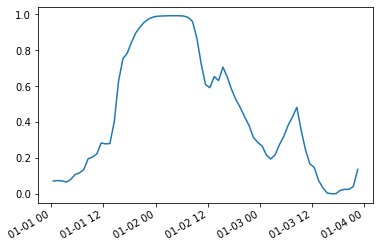

In [13]:
onshore_capacity_factor.iloc[:,0].plot()

In [24]:
wf.time_index

In [20]:
wf.placements

,capacity,hubHeight,rotordiam,lon,lat,powerCurve,roughness
0,4000,120,150,5.985195,50.797254,"SPC:226,25",0.05
1,4000,120,130,5.994685,50.794208,"SPC:301,25",0.05
2,4000,120,150,5.994107,50.800939,"SPC:226,25",0.05
3,4000,120,130,6.004750,50.784432,"SPC:301,25",0.05
4,4000,120,150,6.004174,50.791162,"SPC:226,25",0.03
...,...,...,...,...,...,...,...
555,4000,120,130,6.323312,50.838893,"SPC:301,25",0.50
556,4000,120,150,6.322780,50.845625,"SPC:226,25",0.05
557,4000,120,130,6.333317,50.829087,"SPC:301,25",0.05
558,4000,120,150,6.332788,50.835820,"SPC:226,25",0.05
